## Objetivo: Quanto um cliente de um determinado perfil está disposto a gastar?

A ideia é ter uma equação que permita alteração de parâmetros para avaliar o valor que um determinado cliente gastaria em um dado cenário (definido pelos parâmetros). Nesse sentido, nossa target é o campo "Total Pago (R$)".

O cenário é o conjunto de parâmetros que nós previamente escolhemos para avaliar o potencial de gasto. Em outras palavras, as variáveis que utilizaremos para prever a nossa target. Dessa forma, ele será definido pelos campos:
- Perfil do cliente
- Categoria de item em campanha de marketing
- Desconto total oferecido
- Tempo desde a última compra
- Tempo gasto para decisão

In [1]:
import numpy as np
import pandas as pd
from typing import List
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.ensemble import RandomForestRegressor, IsolationForest, StackingRegressor, AdaBoostRegressor

BASE_PATH = "/media/bruno/Arquivos/Desenvolvimento/LaranjaLima"

## Preparação

Como nossa target é uma variável contínua, estamos diante de um problema de regressão. Antes de acessar os métodos de treino, precisamos garantir que as variáveis categóricas sejam devidamente traduzidas em números. Técnicas de encode como OneHot, Ordinal, Target e outras são úteis nesse ponto. Um cuidado que se deve ter é com relação ao modelo que será testado. Este notebook utiliza o OneHot e o Target, no intuito de demonstrar o impacto e as diferenças entre eles na modelagem.

Em linhas gerais, este tratamento seria o suficiente para o processo de modelagem, uma vez que garantimos que todos os dados de entrada são numéricos. Todavia, ainda existe uma situação comum de ocorrer: campos com dados faltantes. O valor null indica que o valor não existe e pode ser gerado por alguma regra de negócio, falta de captura de informação ou um erro qualquer de processamento. De todo modo, os algoritmos de ajuste simplesmente executam cálculos, portando não vão conseguir lidar com null, afinal não é um número. Scalers são úteis nesse sentido, onde substituímos estes campos vazios por um valor padrão, que pode ser escolhido por meio de uma estratégia qualquer (número fixo, média, mediana, moda ou qualquer outro que julgar interessante). Apesar de estarmos "inserindo" informações que não são "originais" do conjunto de dados, estamos garantindo que os outros campos com números, que podem contribuir positivamente para o modelo, serão considerados no cálculo.

Por fim, ainda podemos realizar um outro tipo de processamento, que é alterar a escala dos valores de entrada. Esse tipo de transformação faz com que não se gerem coeficientes (em modelos que utilizam eles) com grande variação de escala entre si. Deste modo, alinhando com técnicas de regularização, garantimos que variações na entrada não gerem uma variação descontrolada na saída, uma vez que os coeficientes tendem a serem menores e sem muita desigualdade de escala entre eles.

## Processo

Com os dados, tudo que precisamos fazer é invocar os métodos de ajuste de modelo e teremos um pronto para utilizar. Porém, como saber se ele é bom? Para responder essa pergunta, precisaríamos testar este modelo com dados que já conhecemos, e não foram utilizados no ajuste, para saber se o modelo é efetivo, comparando o resultado dado pelo modelo e o valor real. Assim, a estratégia é pegar a nossa base original e repartir ela em duas. Uma parte nós vamos guardar e deixar quieta, ficará "esquecida" enquanto trabalhamos em todo o processo de treino na parte que vamos chamar de *treino*.

Em outra palavras, uma parte dos dados vamos guardar e, no momento oportuno, vamos tratar ela como se fossem dados novos que acabamos de obter. Todo o nosso processo de configuração de encode, definição de metodologia de substituição de null, padronização de valores e o ajuste do modelo serão feitos apenas com a parte de *treino*. As instâncias configuradas neste momento que serão utilizadas no fluxo de predição de novos valores, onde vamos resgatar aquela parte dos dados guardados para avaliar o quão bom o modelo foi.

Nosso processo então pode ser resumido nas seguintes etapas:
1. Carregar os dados existentes;
2. Separar os dados em duas partes, uma para treino e outra para teste;
3. Definir o campo que contêm a nossa target;
4. Definir os campos das variáveis preditoras (entrada do modelo), identificando o que é categórico e o que é numérico;
5. Ajustar as instâncias de encode, substituição e padronização utilizando apenas a base de treino;
6. Aplicar as transformações definidas anteriormente nos campos que representam as variáveis de entrada;
7. Instanciar o modelo que será testado, com as devidas particularidades (hyper parâmetros);
8. Utilizar os dados transformados em (6) para ajustar o modelo instanciado em (7);
9. Definir uma métrica de avaliação;
10. Recuperar os dados de teste e aplicar as mesmas transformações de (6);
11. Avaliar o resultado da métrica definida em (9) nos dados de teste e comparar com o resultado obtido no treino;
10. Caso o modelo seja bom, utilizar em novos dados, sempre aplicando as transformações de (6) antes de utilizar o modelo.

A classe criada abaixo tem como função implementar estes passos em alto nível, permitindo que o fluxo de execução se torne mais simples e o processo se torne mais fluido de executar, com as alterações mais importantes visíveis e o processo "maçante" encapsulado nos métodos.

In [2]:
class Pipe:
    def __init__(self, df: pd.DataFrame) -> None:
        self.__base_data = df
        self.__encoder = OneHotEncoder(sparse_output=False)
        self.__imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
        self.__scaler = StandardScaler()
        self.__outliers = IsolationForest()
        self.__categorical_columns: List[str] = None
        self.__numeric_columns: List[str] = None
        self.__target_column: str = None

    def set_categorical_columns(self, columns: List[str]) -> None:
        self.__categorical_columns = columns

    def set_numeric_columns(self, columns: List[str]) -> None:
        self.__numeric_columns = columns

    def set_target_column(self, column: str) -> None:
        self.__target_column = column

    def set_encoder(self, encoder) -> None:
        self.__encoder = encoder

    def set_dataset(self, df: pd.DataFrame) -> None:
        self.__base_data = df

    def get_categorical_columns(self) -> List[str]:
        return [c for c in self.__categorical_columns]
    
    def get_numeric_columns(self) -> List[str]:
        return [c for c in self.__numeric_columns]
    
    def get_target_column(self) -> str:
        return self.__target_column
    
    def get_encoder(self):
        return self.__encoder

    def split(self, test=0.3) -> None:
        self.train, self.test = train_test_split(self.__base_data, test_size=test, random_state=666)

    def fit_preprocess(self) -> None:
        np_cat, np_num = self.__divide(self.train)
        if np_cat is not None:
            np_cat = self.__encoder.fit_transform(np_cat, self.train[self.__target_column].values)

        x = self.__concatenete(np_cat, np_num)
        x = self.__imputer.fit_transform(x)
        x = self.__scaler.fit_transform(x)
        self.__outliers.fit(x)

    def transform_data(self, df: pd.DataFrame) -> np.ndarray:
        np_cat, np_num = self.__divide(df)
        if np_cat is not None:
            np_cat = self.__encoder.transform(np_cat)

        x = self.__concatenete(np_cat, np_num)
        x = self.__imputer.transform(x)
        x = self.__scaler.transform(x)
        return x
    
    def train_model(self, model, remove_outliers=False) -> None:
        x = self.transform_data(self.train)
        y = self.train[self.__target_column].values

        if remove_outliers:
            outliers = self.__outliers.predict(x)
            x_train, y_train = [], []
            for i in range(0, len(outliers)):
                if outliers[i] == 1:
                    x_train.append(x[i])
                    y_train.append(y[i])
        else:
            x_train, y_train = x, y

        model.fit(x_train, y_train)

        x_test = self.transform_data(self.test)
        y_test = self.test[self.__target_column].values

        print(f"MAE treino: {mean_absolute_error(y_train, model.predict(x_train))}")
        print(f"MAE teste: {mean_absolute_error(y_test, model.predict(x_test))}")

    def predict(self, df: pd.DataFrame, model) -> np.ndarray:
        x = self.transform_data(df)
        return model.predict(x)

    def show_graphs(self, models: list):
        fig, ax = plt.subplots(len(models), 2, figsize=(20, 5 * len(models)))
        df_train = self.train.sample(100)
        df_test = self.test.sample(100)

        for i in range(0, len(models)):
            # De acordo com a quantidade de linhas do subplot, altera a forma de acesso
            if len(models) == 1: axi = ax
            else: axi = ax[i]

            # Configura a exibição da performance em treino
            x = [j for j in range(0, len(df_train))]
            real = df_train[self.__target_column].values
            pred = self.predict(df_train, models[i])
            axi[0].set_ylabel("R$ gasto")
            axi[0].set_xlabel("Observação")
            axi[0].scatter(x, real, color="#000000", s=20, label="Real")
            axi[0].scatter(x, pred, color="#567a0d", s=8, label="Predição")
            axi[0].set_title(f"Performance no treino do modelo {models[i].__class__.__name__}", fontdict={"fontsize": 14}, pad=10)
            for j in range(0, len(x)):
                axi[0].vlines(j, ymax=real[j], ymin=pred[j], colors="#888888")
            axi[0].legend()

            # Configura a exibição da performance em teste
            x = [j for j in range(0, len(df_test))]
            real = df_test[self.__target_column].values
            pred = self.predict(df_test, models[i])
            axi[1].set_ylabel("R$ gasto")
            axi[1].set_xlabel("Observação")
            axi[1].scatter(x, real, color="#000000", s=20, label="Real")
            axi[1].scatter(x, pred, color="#567a0d", s=8, label="Predição")
            axi[1].set_title(f"Performance no teste do modelo {models[i].__class__.__name__}", fontdict={"fontsize": 14}, pad=10)
            for j in range(0, len(x)):
                axi[1].vlines(j, ymax=real[j], ymin=pred[j], colors="#888888")
            axi[1].legend()
        
        plt.show()
    
    def __divide(self, df: pd.DataFrame) -> List[np.ndarray]:
        if self.__categorical_columns is None and self.__numeric_columns is not None:
            return None, df[self.__numeric_columns].values
        
        if self.__categorical_columns is not None and self.__numeric_columns is None:
            return df[self.__categorical_columns].values, None
        
        return df[self.__categorical_columns].values, df[self.__numeric_columns].values
    
    def __concatenete(self, np1: np.ndarray=None, np2: np.ndarray=None):
        if np1 is None and np2 is not None:
            return np2
        if np2 is None and np1 is not None:
            return np1
        
        return np.concatenate((np1, np2), axis=1)

## Escolhendo o modelo

O processo para executar o ajuste de um modelo qualquer é sempre o mesmo, com pequenas alterações de acordo com a particularidade do modelo, como alterar o tipo de estratégia de encode para categóricas. Para saber se é necessário alguma alteração, basta conhecer o processo matemático utilizado pelo modelo. O scikit-learn possui uma documentação geral sobre as técnicas implementadas, é bom sempre conferir [aqui](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

Neste notebook vamos utilizar três modelos regressivos no intuito de explorar algumas particularidades de cada. São eles: linear, máquinas de suporte e árvore de decisão. Também vamos utilizar dois ensembles: ávores randômicas e stacking. Na maioria das vezes em problemas de regressão, modelos lineares são bem úteis: rápidos e com uma capacidade de predição razoável, mas nosso intuito neste momento é explorar um pouco mais sobre as particularidades. A escolha do modelo não é simplemente aleatória, é uma combinação entre conhecimento técnico e conhecimento de negócio, que permite identificar em qual modelagem o problema melhor se encaixa.

## Avaliando métricas

Para ser fácil de interpretar, vamos utilizar o erro absoluto médio (MAE). Lembrando que esta não é a função de perda utilizada na modelagem, vamos utilizar o MAE na nossa avaliação e comparação entre performance no treino e teste, já que o resultado do MAE, no nosso caso, será um valor em Real e não $Real^2$, como no caso do MSE.

De modo geral, os modelos de máquinas de suporte e linear não apresentam indícios de overfitting, já que não vemos um baixo valor de MAE no treino e um alto valor no teste. O caso contrário acontece com árvores, onde percebemos claramente um overfitting. De fato, modelos de árvores, quando muito grandes ou com diversos parâmetros, tendem ao overfitting, assim o nosso trabalho é alterar algo para quebrar esse fato.

Algo importante é que, ao olharmos os gráficos representativos da previsão no treino e no teste, percebemos que os modelos de máquinas de suporte e linear são incapazes de prever valores altos. Em outras palavras, estamos diante de um caso de modelos com alto viés. Mesmo removendo a regularização ou alterando os parâmetros, não conseguimos chegar em uma situação onde quebramos o viés destes modelos.

Por outro lado, a troca de parâmetros aparenta ter um impacto maior no modelo de árvore. Obviamente, como em casos de regressão as folhas das árvores atuam como preditores não contínuos, ou seja, seus valores vão sempre ser espelhos do que foi apresentado no treino, ainda teremos um forte overfitting e uma baixa capacidade de predição. Alterar o tamanho máximo da árvore também ajuda na quebra do overfitting, impedindo que a árvore crie nós extremamente especializados nos dados utilizados no treino.

In [57]:
dataset = pd.read_csv(f"{BASE_PATH}/data/ml/ecommerce - python - gasto dos clientes.csv")
pipe = Pipe(dataset)
pipe.split(test=0.3)
pipe.set_target_column("Total Pago (R$)")
pipe.set_categorical_columns(["Perfil do Cliente", "Categoria"])
pipe.set_numeric_columns([
    "Desconto Total (%)",
    "Tempo desde a Última Compra (dias)",
    "Tempo para Finalizar Compra (min)"
])
pipe.fit_preprocess()

### Modelo linear

Nosso primeiro modelo é o linear implementando o gradiente como técnica de solução. Apesar de ser um dos modelos mais simples, isso não o torna "inútil". Consegue ter uma eficiência interessante, não apresentando sinais de overfitting e nem de underfitting. O primeiro podemos inferir pela proximidade do erro obtido tanto em treino quanto em teste. Já o underfitting também não parece ser problema, uma vez que o valor numérico do erro (aproximadamente R$ 380,00) não é alto para o nosso caso.

Um ponto interessante de observação é que esse modelo funciona muito bem para valores gastos menores, porém erra mais para gastos elevados. De fato, por ser linear, sua base é uma equação contínua e, como os preços dos produtos nas categorias não crescem linearmente, podemos entender um pouco este comportamento. Sabendo disso, seria interessante incluir uma nova feature que daria uma diferenciação de preço médio por produto, para fazer com que o modelo fosse mais eficiente?

Não precisamos nem mesmo criar uma nova feature, vamos apenas trocar o encoder padrão de One Hot para Target. Este encoder substitui a variável categória pelo valor médio da variável target para a categoria em questão. Em outras palavras, estaremos fornecendo ao modelo o quanto um cliente de determinado perfil gasta em média e o quanto é consumido em média em cada item da categoria. A alteração é bem imperceptível. Após a conclusão desta análise inicial de modelos, voltaremos a discutir sobre este assunto.

Testando modelo linear com one hot encoder
MAE treino: 394.07216955040553
MAE teste: 396.0854263091367


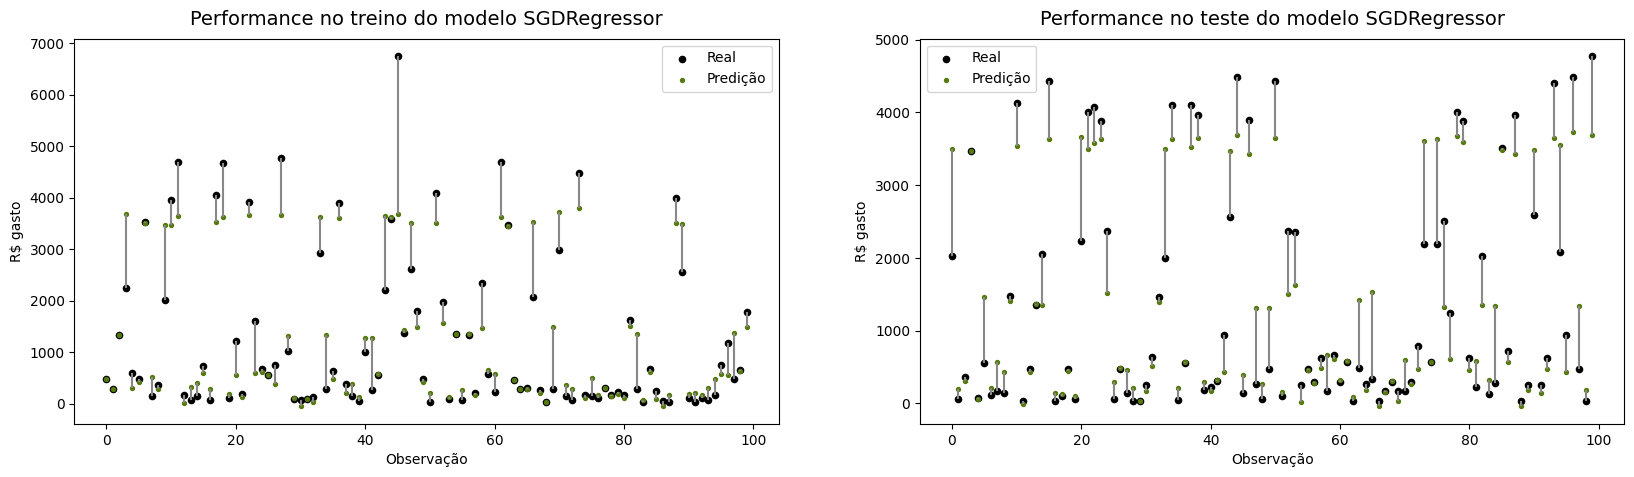

Testando modelo linear com target encoder
MAE treino: 557.2686529003547
MAE teste: 591.3282734273079


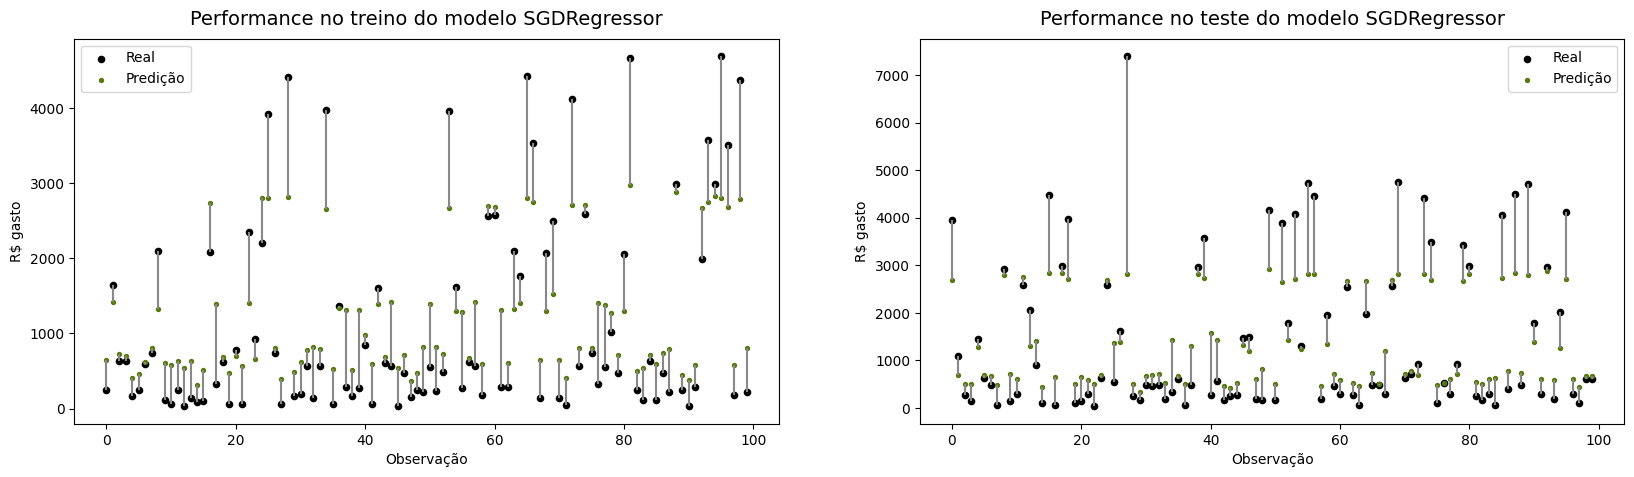

In [59]:
print("Testando modelo linear com one hot encoder")
linear_model = SGDRegressor(loss="squared_error", penalty="l2", alpha=0.01, eta0=0.01, learning_rate="optimal")
pipe.train_model(linear_model, remove_outliers=False)
pipe.show_graphs([linear_model])

pipe.set_encoder(TargetEncoder())
pipe.fit_preprocess()

print("Testando modelo linear com target encoder")
linear_model = SGDRegressor(loss="squared_error", penalty="l2", alpha=0.5, eta0=0.01, learning_rate="optimal")
pipe.train_model(linear_model, remove_outliers=False)
pipe.show_graphs([linear_model])

### Modelo de máquinas de suporte

Este modelo tem grande aplicação em classificação, mas vamos explorar apenas algumas coisas aqui. Ele é um tanto "estranho" de se entender, sobretudo para a regressão. A ideia é traçar hiperplanos e conter os dados dentro deles, assim os vetores que são desenhados lá são responsáveis por fazer as predições. Para tornar possível a separação dos dados dentro dos hiperplanos, a função de kernal (ou função de núcleo) aplica alguma transformação nos dados para isso. Por exemplo a RBF faz um cálculo semelhante ao z, muito utilizado em estatística.

Não vale muito a pena tentar cobrir a teoria desta modelagem aqui, vamos nos contentar em deixar alguns links para melhor estudo. De todo modo, podemos identificar uma eficiência média bem próxima ao modelo linear, com uma capacidade um pouco maior de prever valores altos. Principalmente alteramos o parâmetro C, responsável pela "força" da regularização, que é o fundamento do método ao encontrar os hiperplanos.

Alguns links:
- https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2
- https://geam.paginas.ufsc.br/files/2020/02/svm.pdf
- https://www.inf.ufpr.br/dagoncalves/IA07.pdf


Testando modelo de máquinas de suporte
MAE treino: 371.2669838316
MAE teste: 392.6579616657062


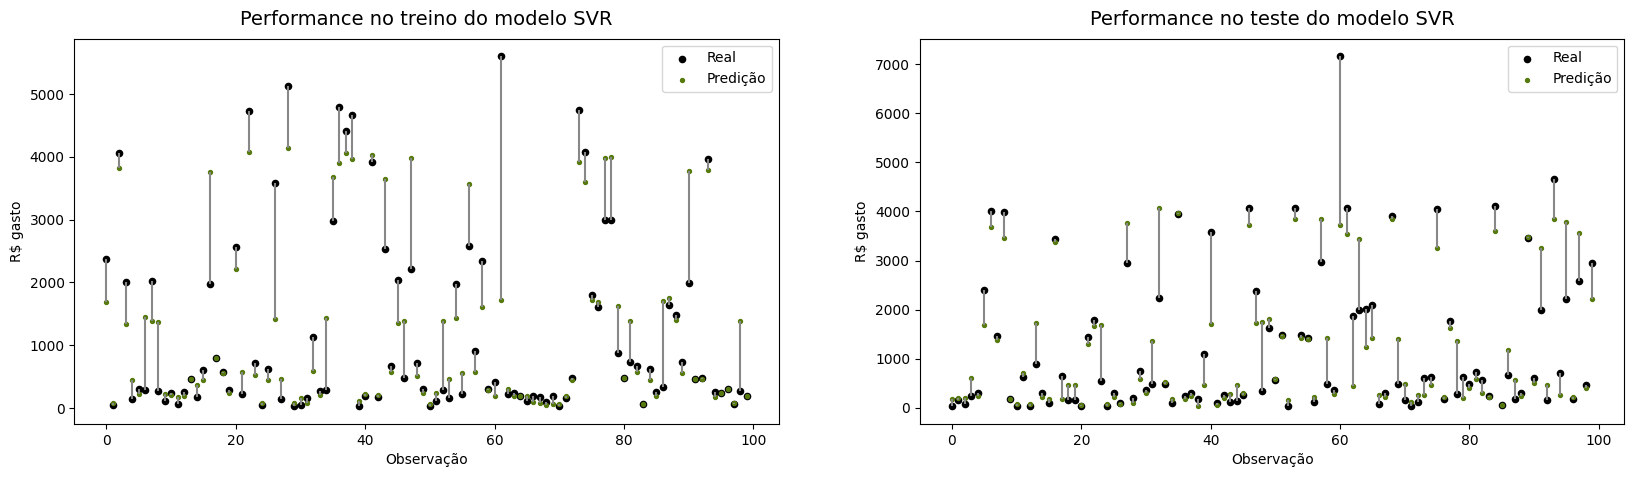

In [60]:
print("\nTestando modelo de máquinas de suporte")
svm_model = SVR(kernel="rbf", C=1000, epsilon=0.1)
pipe.train_model(svm_model, remove_outliers=False)
pipe.show_graphs([svm_model])

### Modelo de árvores de decisão

As árvores são muito queridas, são simples e eficientes. Porém, a estratégia de split e regras utilizada inclui não continuidade para problemas de regressão. Isso significa que nosso valores previstos passam a ser "quantizados" de acordo com o apresentado no treino. Em alguns casos, isso pode gerar uma baixa capacidade de extrapolação do modelo, o que necessita de cuidado.

Este modelo é conhecido pela sua tendência ao overfittin, ou seja, ele vai achar regras fortemente específicas para o conjunto de treino, porém que nem sempre se mostraram certas ao testarmos com dados diferentes. Novamente, isso ocorre pela metodologia de split, que sempre vai buscar uma folha com maior pureza. Assim, uma forma de contornar este problema é limitando o tamanho da árvore, para não ocorrer de terem folhas muito especializadas em regras do treino, aumentando a capacidade de generalização.

Outra forma de trabalhar é com ensemble, sendo as florestas randômicas um bem conhecido. Este modelo trabalha com bagging e bootstrap, ou seja, treina um número X de árvores, cada uma com uma amostra do dataset tomada com reposição, e o resultado final é a média de cada árvore (ou a moda, para problemas de classificação).

OBS.: Como no passo da regressão linear o encoder foi trocado do One Hot para Target, aqui nós não teríamos um problema de aumento de dimensionalidade ocasionado pelo One Hot, que pode ser problemático para árvores. Quando maior a dimensão da matriz de entrada, mais splits ocorrem e mais regras muito específicas (e as vezes "inúteis" quando pensamos nas colunas binárias do One Hot) são criadas, levando a mais chance de overfitting.


Testando modelo de árvore de decisão
MAE treino: 26.919226911001168
MAE teste: 503.40585144730585

Testando o modelo de florestas
MAE treino: 163.9904572123017
MAE teste: 418.17834851140327


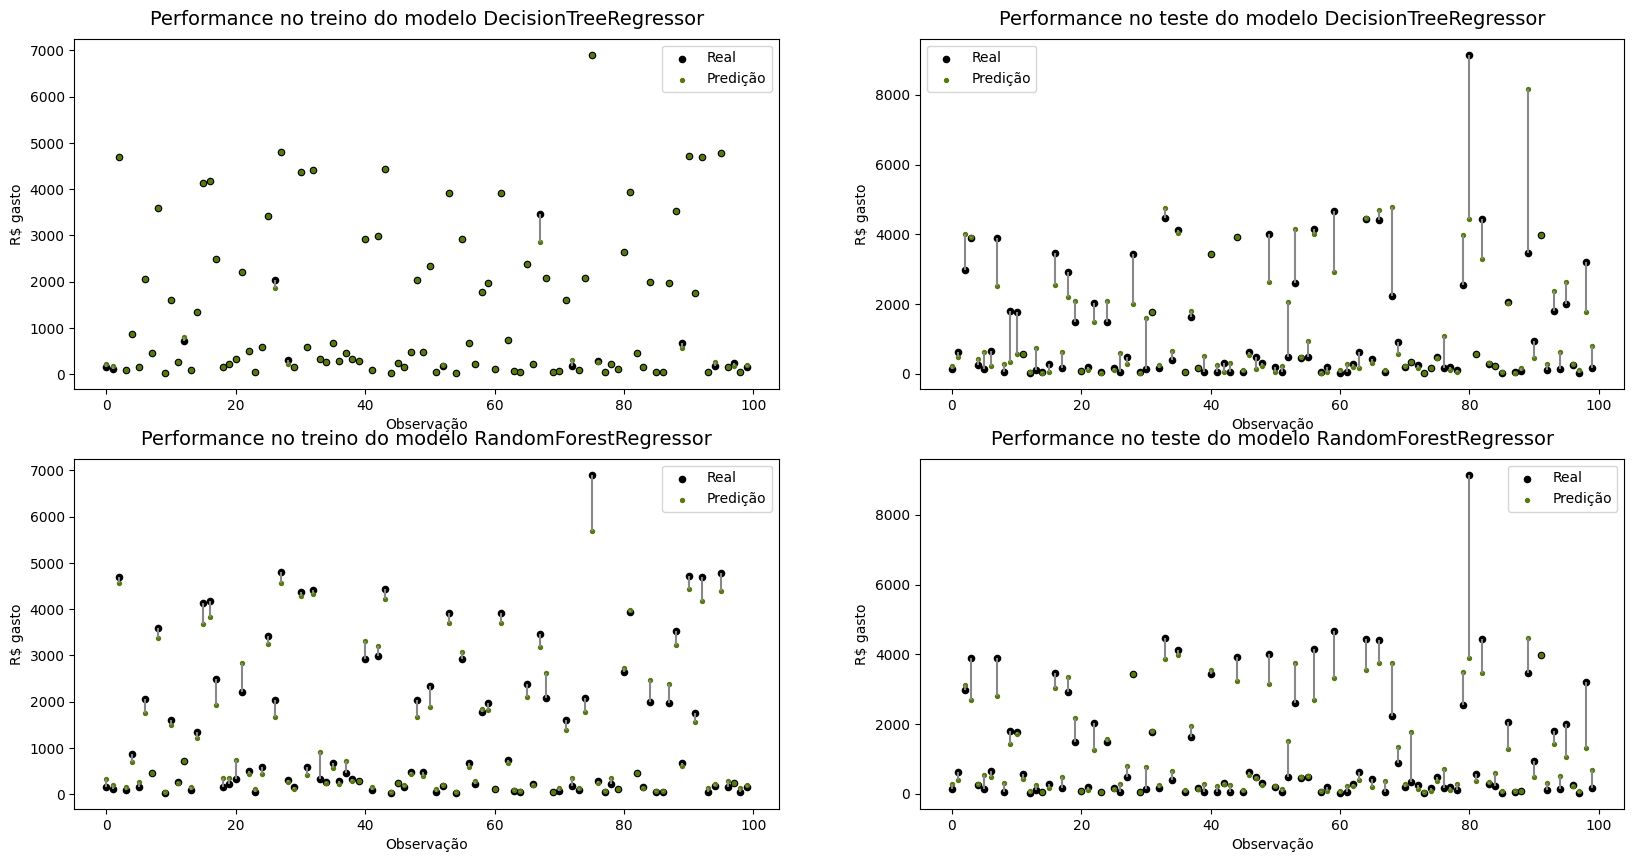

In [61]:
print("\nTestando modelo de árvore de decisão")
dt_model = DecisionTreeRegressor(max_depth=20)
pipe.train_model(dt_model, remove_outliers=False)

print("\nTestando o modelo de florestas")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
pipe.train_model(rf_model, remove_outliers=False)
pipe.show_graphs([dt_model, rf_model])

### Empilhamento (stacking)

Não se trata de um modelho em essência, trata-se de uma estratégia de ensemble onde treinamos diversos modelos com os dados e o resultado de cada um nós fornecemos a um outro modelo, que então compila o resultado final. Assim, precisamos definir quais são os modelos da pilha e qual o modelo será responsável por compilar os dados. Continuando com nosso Target Encoder, vamos jogar na pilha todos os modelos que testamos anteriormente. Para a compilação final, deixemos o padrão do scikit-learn, que é um modelo linear com regularização l2.

O resultado entregue funciona muito bem para gastos pequenos e já melhora bastante a capacidade de prever valores altos, o que era bem difícil para o modelo linear sozinho. Esta é uma das grandes qualidades do stacking, podemos dizer que ele pega o melhor de cada modelo.


Testando o stacking
MAE treino: 409.0090862294891
MAE teste: 402.14141776089565


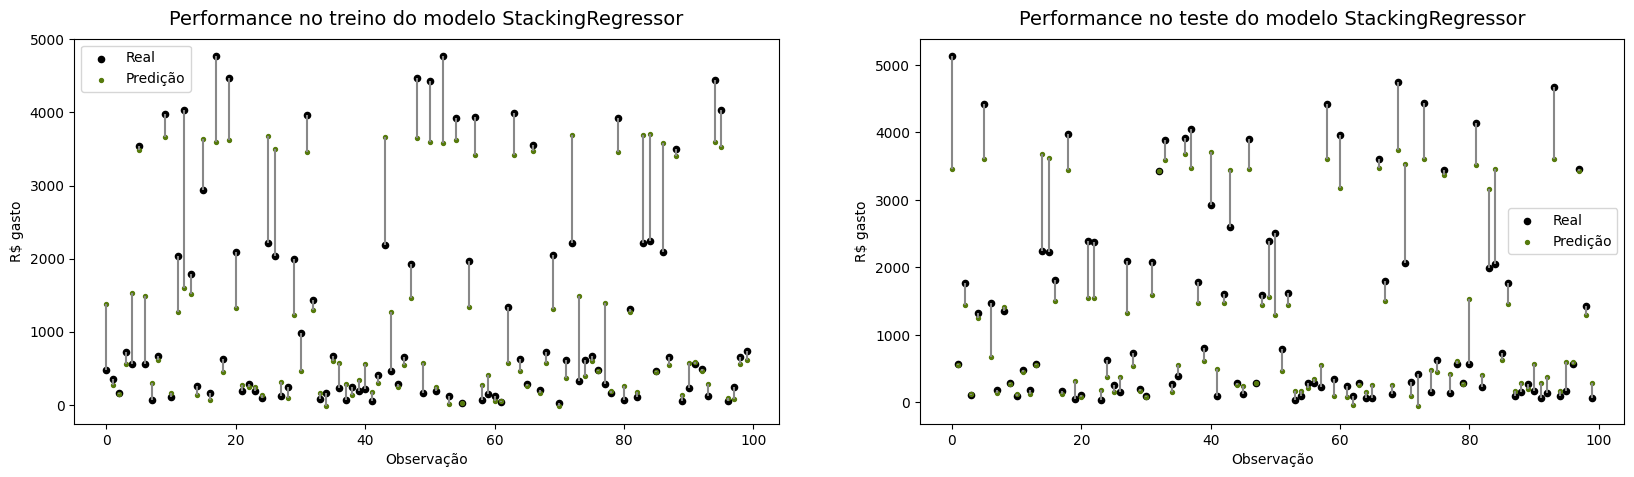

In [62]:
print("\nTestando o stacking")
models = [
    ("linear", SGDRegressor(loss="squared_error", penalty="l2", alpha=0.5, eta0=0.01, learning_rate="optimal")),
    ("svr_rbf", SVR(kernel="rbf", C=1000, epsilon=0.1)),
    ("arvore", DecisionTreeRegressor(max_depth=20)),
    ("floresta", RandomForestRegressor(n_estimators=100, max_depth=20))
]
stack_model = StackingRegressor(estimators=models)
pipe.train_model(stack_model, remove_outliers=False)
pipe.show_graphs([stack_model])

## Conclusão

O trabalho de modelagem é essa briga para conseguir o modelo com menor viés e menor variância, para isso padronizamos todo um processo de tratamento e definimos as melhores condições de parâmetros para cada modelo. Em alguns momentos o modelo pode ser enviesado e prever valores bem restritos, não importando a entrada, e em outros momentos o modelo pode apresentar uma variação tão grande quando testamos que parece que um chute aleatório seria mais eficiente.

De todo modo, temos aqui duas abordagens interessantes. A primeira é aceitar o erro de predição para gastos elevados do modelo linear e utilizar ele, devido a sua simplicidade, ou partirmos para o stacking, que parece corrigir esta incapacidade, porém ao custo do tempo de processamento.

Todavia, ainda podemos fazer um outro teste. É crível supor que o gasto não aumenta linearmente com o preço do produto, dessa forma, podemos voltar ao notebook de *feature_engineering* e incluir uma nova coluna chamada **Preço Médio da Categoria**, onde iremos trabalhar com ela em potenciação. Vamos testar isto nos próximos passos.

## Utilizando o modelo

Ao passarmos por todo o processo de ajuste, podemos finalmente utilizar nosso modelo para ativamente prever o comportamento de um cliente qualquer em uma situação que definirmos. Em outras palavras, podemos testar cenários diversos para um mesmo cliente. Por exemplo, podemos variar o tempo gasto para fechar a compra ou o tempo desde a última vez que ele fez alguma compra. Isso pode gerar direcionamentos para o time de marketing, que vai saber passar a ter metas numéricas para perseguir e alcançar melhores resultados.

Vamos tomar como exemplo o cliente que identificamos como "o mais importante", aquele que mais gera receita para a gente. Demos o nome para ele de *Médio ticket e alta frequência*, então vamos já definir o perfil do cliente como este. Agora, vamos fazer alguns testes.

Suponhamos o seguinte cenário: sabemos que fazem 10 dias desde que o nosso cliente comprou algo com a gente, então iremos oferecem um desconto de 1% em Livros para ele fazer uma nova compra. Sabendo que o tempo médio para tomada de decisão é de 15 minutos, se nós fizermos com que ele decida em menos tempo, quanto a mais ele gastaria?

Com nosso modelo pronto, basta criar a matriz de entrada e solicitarmos a predição, de modo que saberemos em cada caso, qual o valor que ele gastaria. Com isso, podemos alimentar o time de marketing e venda para construir uma meta e calcular o quanto nosso modelo representa de ganho. Temos no total 50 clientes deste perfil e, se considerarmos que conseguimos fazer com que 50% deles decidam mais rápido, faremos em torno de R$ 700,00 extra de receita, utilizando modelagem preditiva para nos auxiliar nesse processo de decisão. Os detalhes da implementação estão no código abaixo.

Claro, ainda é possível juntar essa abordagem com outras, como a aquisição de novos clientes, retenção e aumento de frequência, para citar algumas. Isso tudo depende do seu negócio e necessidade no momento da análise. Aqui nós focamos mais na parte técnica, porém é de grande importância ter também a visão estratégia do negócio, ou seja, trazer para a discussão pessoas responsáveis por outras áreas como produção, logística, marketing e vendas. A contribuição dessas pessoas permite criar cada vez mais cenários, que podem ser combinados em uma análise cada vez mais robusta e com cada vez mais ganho.

OBS.: Sempre bom lembrar que aqui estamos trabalhando com dados simulados em um sistema muito controlado. Apesar das lógicas de funcionamento poderem ser aplicadas na vida real, não tente levar para o seu problema os valores que são apresentados aqui. Em outras palavras, não nos preocupamos em ter escalas de valores reais (como preços de produtos, gastos e vendas), nos preocupamos mais com as lógicas e relações entre os dados. Portanto, não podemos assumir que em qualquer loja, a modelagem apresentada aqui vai gerar o mesmo ganho de receita, já que as escalas serão diferentes para cada caso.

In [118]:
# Definição da matriz de entrada para a avaliação de cenários
columns = [
    "Perfil do Cliente", "Categoria", "Desconto Total (%)",
    "Tempo desde a Última Compra (dias)", "Tempo para Finalizar Compra (min)"
]
profile = "Médio ticket e alta frequência"
cases = [
    [profile, "Eletrodomésticos", 1, 10, 15],
    [profile, "Eletrodomésticos", 1, 10, 10],
    [profile, "Eletrodomésticos", 1, 10, 5],

    [profile, "Livros", 1, 10, 15],
    [profile, "Livros", 1, 10, 10],
    [profile, "Livros", 1, 10, 5],

    [profile, "Livros", 1, 10, 15],
    [profile, "Livros", 1, 20, 15],
    [profile, "Livros", 1, 30, 15]
]
pred = pipe.predict(pd.DataFrame(cases, columns=columns), linear_model)

# Cálculo para identificar o potencial de ganho seguindo a estratégia do modelo
n_customers = 50
conversion = 0.5
time_between_purchases = 10
period = 30
gain = n_customers * conversion * int(period / time_between_purchases) * (pred[5] - pred[3])
print(f"Ganho de receita estimado na redução do tempo de decisão na compra de livros: R$ {round(gain, 2)}")

Ganho de receita estimado na redução do tempo de decisão na compra de livros: R$ 656.83


## Incluindo nova feature

Incluímos no *feature_engineering.ipynb* um passo para calcular o preço médio de itens vendidos em cada categoria. Também foi incluído esse preço elevado ao quadrado, para incluir a informação de exponencialidade no modelo. Com isso, vamos reaplicar os mesmos passos feitos anteriormente, porém agora com novas features.

Nesta nova abordagem, vamos alterar também alguns parâmetros, removendo a tempo para finalização da compra. Nossa nova modelagem provoca uma diminuição no erro entre R$ 20,00 e R$ 50,00. Também faremos um teste de cenário diferente. Se antes nós alteramos o tempo para tomada de decisão, agora vamos mexer no intervalo de compra, ou seja, no tempo desde a última compra. Esta abordagem requer um pouco mais de cuidado, pois aqui vamos avaliar o período de 1 mês e testar as diferentes possibilidades de frequência de compra. Acredito ser mais vantajoso a observação do código no lugar de descrever aqui o processo.

De todo modo, aqui nós utilizamos outras features e ainda trocamos a forma de calcular o cenário, ou o ganho do nosso modelo. Meu objetivo aqui era mostrar que esse processo não é escrito na pedra. Não existem features certas ou erradas, não existe uma única forma de modelar ou calcular o retorno financeiro do modelo. Aqui passamos por duas formas, mas que dependem do conhecimento do negócio. Quais parâmetros ajustar, quais alinhamentos com outros times (marketing, venda e etc) serão feitos e, principalmente, o que é factível de ser feito. Por fim, gaste tempo estudando o seu negócio, além de estudar também os dados e as técnicas.

In [87]:
dataset = pd.read_csv(f"{BASE_PATH}/data/ml/ecommerce - python - gasto dos clientes.csv")
categories_data = {}
for category in set(dataset["Categoria"]):
    categories_data[category] = dataset.query(f"Categoria == '{category}'")["Preço Médio da Categoria"].mean()

pipe = Pipe(dataset)
pipe.split(test=0.3)
pipe.set_target_column("Total Pago (R$)")
pipe.set_categorical_columns(["Perfil do Cliente", "Categoria"])
pipe.set_numeric_columns([
    "Desconto Total (%)",
    "Tempo desde a Última Compra (dias)",
    "Preço Médio da Categoria",
    "Preço Médio da Categoria 2"
])
pipe.set_encoder(TargetEncoder())
pipe.fit_preprocess()

print("Testando modelo linear")
linear_model = SGDRegressor(loss="squared_error", penalty="l2", alpha=0.5, eta0=0.01, learning_rate="optimal")
pipe.train_model(linear_model, remove_outliers=False)

print("\nTestando modelo de máquinas de suporte")
svm_model = SVR(kernel="rbf", C=1000, epsilon=0.1)
pipe.train_model(svm_model, remove_outliers=False)

print("\nTestando modelo de árvore de decisão")
dt_model = DecisionTreeRegressor(max_depth=20)
pipe.train_model(dt_model, remove_outliers=False)

print("\nTestando o modelo de florestas")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
pipe.train_model(rf_model, remove_outliers=False)

print("\nTestando o stacking")
models = [
    ("linear", SGDRegressor(loss="squared_error", penalty="l2", alpha=0.5, eta0=0.01, learning_rate="optimal")),
    ("svr_rbf", SVR(kernel="rbf", C=1000, epsilon=0.1)),
    ("arvore", DecisionTreeRegressor(max_depth=20)),
    ("floresta", RandomForestRegressor(n_estimators=100, max_depth=20))
]
stack_model = StackingRegressor(estimators=models)
pipe.train_model(stack_model, remove_outliers=False)

Testando modelo linear com one hot encoder
MAE treino: 473.5018289617991
MAE teste: 494.1337248861635

Testando modelo de máquinas de suporte
MAE treino: 372.6610046866213
MAE teste: 377.59217977769634

Testando modelo de árvore de decisão
MAE treino: 56.8639255860474
MAE teste: 504.3377726743194

Testando o modelo de florestas
MAE treino: 181.63762784109363
MAE teste: 427.5817653976952

Testando o stacking
MAE treino: 385.9936288298793
MAE teste: 404.0812209694392


In [94]:
# Definição da matriz de entrada para a avaliação de cenários
columns = [
    "Perfil do Cliente", "Categoria", "Desconto Total (%)",
    "Tempo desde a Última Compra (dias)", "Preço Médio da Categoria",
    "Preço Médio da Categoria 2"
]
profile = "Médio ticket e alta frequência"
category = "Eletrodomésticos"
off = 1
price, price2 = categories_data[category], categories_data[category] ** 2

# Definições das condições do cenário, sendo o primeiro intervalo (7 dias)
# a média de intervalo de compra dos clientes hoje
customers = 50
conversion = 0.5
total_days = 30
mean_interval = 7
intervals = [3, 5, 9, 11, 13, 15]

for interval in intervals:
    # Cada intervalo entre compras determina a quantidade de vezes que um
    # cliente faz uma compra dentro do mês
    times = int(total_days / interval)
    base_times = int(total_days / mean_interval)

    # Para as condições do teste, calcula o total gasto pelo cliente
    cases = [
        [profile, category, off, interval, price, price2],
        [profile, category, off, mean_interval, price, price2],
    ]
    pred = pipe.predict(pd.DataFrame(cases, columns=columns), stack_model)

    # Computa, dado todo o cenário, o total arrecadado no mês
    convert_customers = customers * conversion
    base_spent = customers * pred[1] * base_times
    new_spent = convert_customers * pred[0] * times + (customers - convert_customers) * pred[1] * base_times
    growth = (new_spent - base_spent)  * 100 / base_spent

    print(f"No intervalo de compras de {interval}, temos:")
    if new_spent > base_spent:
        print(f"Aumento da receita em {round(growth, 2)}%, de R$ {round(base_spent, 2)} para R$ {round(new_spent, 2)}.")
    elif new_spent < base_spent:
        print(f"Redução da receita em {round(growth, 2)}% de R$ {round(base_spent, 2)} para R$ {round(new_spent, 2)}.")
    else:
        print("Não há alteração na receita")
    print()

No intervalo de compras de 3, temos:
Aumento da receita em 74.17%, de R$ 285016.28 para R$ 496422.84.

No intervalo de compras de 5, temos:
Aumento da receita em 26.83%, de R$ 285016.28 para R$ 361478.86.

No intervalo de compras de 9, temos:
Redução da receita em -11.74% de R$ 285016.28 para R$ 251567.95.

No intervalo de compras de 11, temos:
Redução da receita em -24.69% de R$ 285016.28 para R$ 214637.92.

No intervalo de compras de 13, temos:
Redução da receita em -25.77% de R$ 285016.28 para R$ 211559.63.

No intervalo de compras de 15, temos:
Redução da receita em -25.58% de R$ 285016.28 para R$ 212095.34.

